# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through analyzing the dataset, with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

> How well can we predict the sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?


## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:

* Have a header: "SalesID,SalePrice"
* Contain two columns
    * SalesID: SalesID for the validation set in sorted order
    * SalePrice: Your predicted price of the sale
    
**Note:** The goal for most regression evaluation metrics is to minimize the error. Our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

In [2]:
# Importing basic tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Import training and validation sets
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [6]:
df.shape

(412698, 53)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [9]:
df.isna().sum() / len(df)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

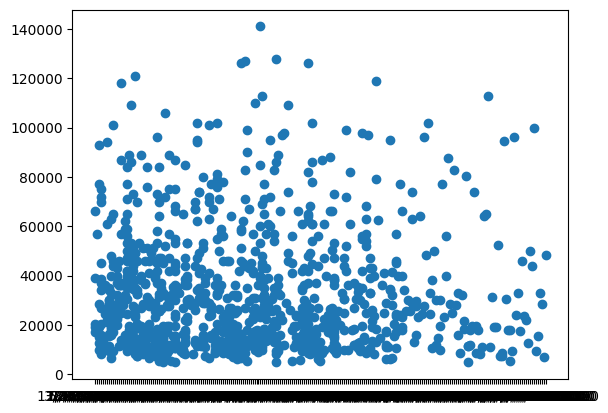

In [12]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

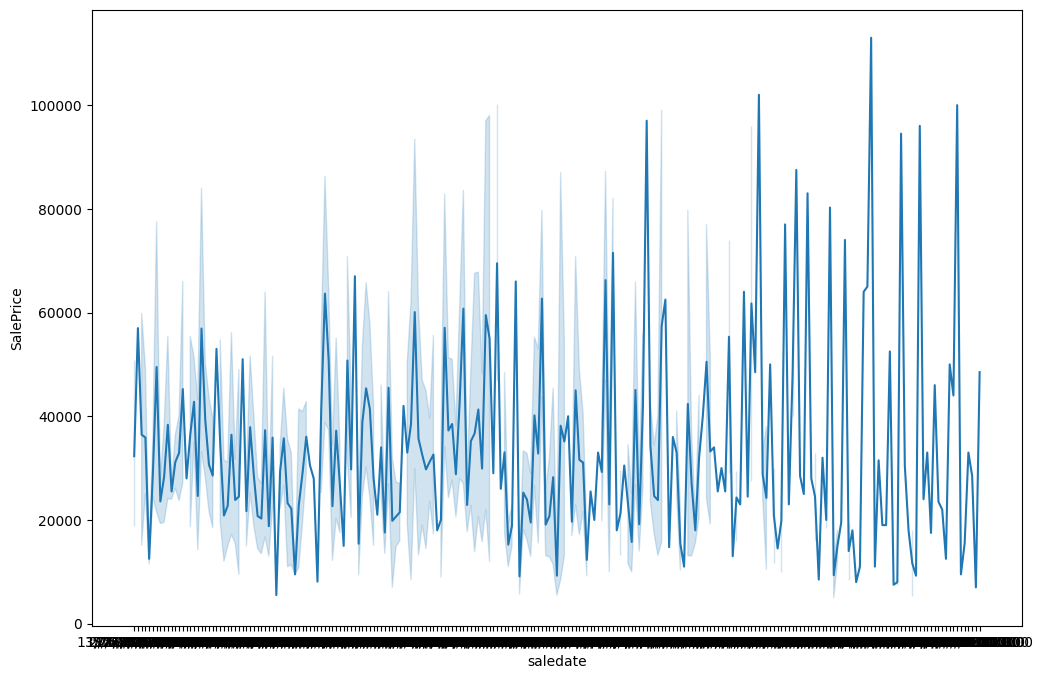

In [14]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df['saledate'][:1000], y=df['SalePrice'][:1000]);

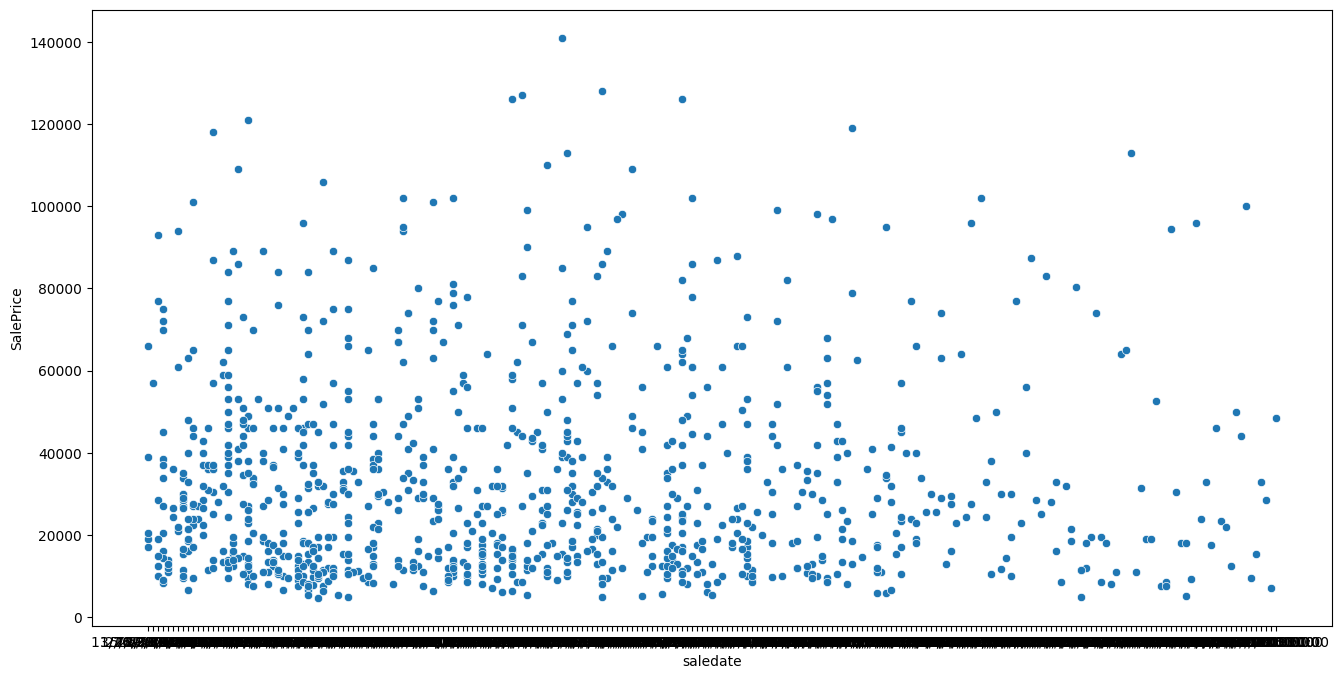

In [17]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=df[:1000], x = 'saledate', y = 'SalePrice');

In [31]:
df['saledate'].head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

### Parsing dates

When we work with time series data, we want to enrich the time * date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using `parse_dates` parameter.

In [31]:
## Importing df assigning date in date format.
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=['saledate'])

In [3]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

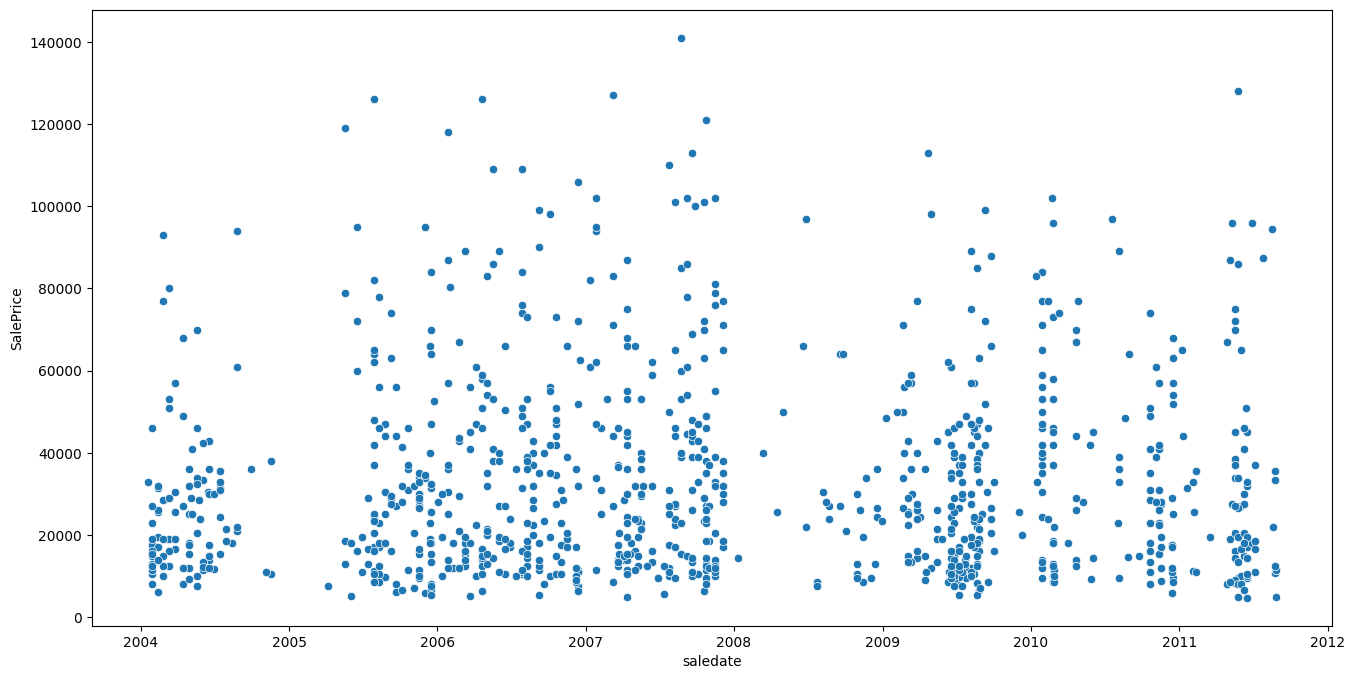

In [32]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=df[:1000], x = 'saledate', y = 'SalePrice');

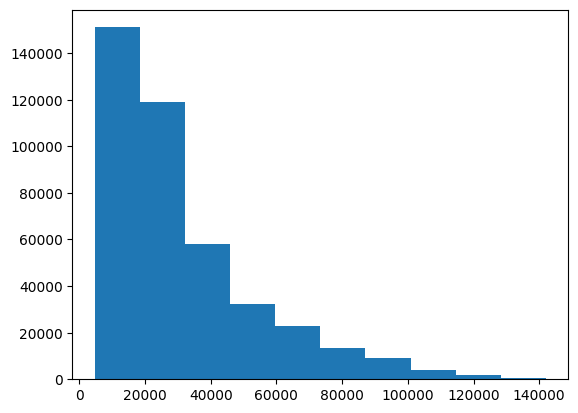

In [24]:
# plt.figure(figsize=(10,8))
plt.hist(df['SalePrice']);

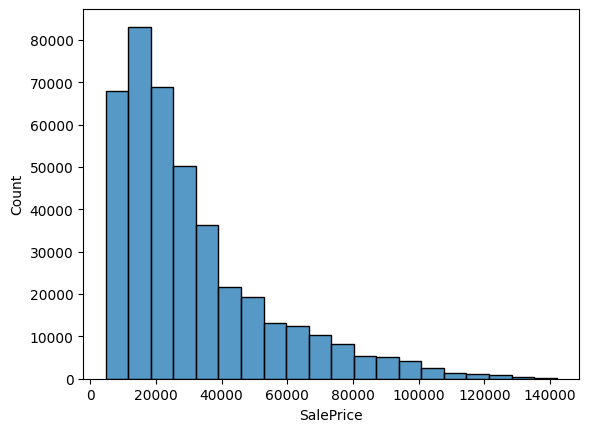

In [26]:
sns.histplot(df['SalePrice'], bins=20);

### Sort DataFrame by saledate.

When working with time series data, it's a good idea to sort it by date.

In [41]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

In [33]:
# Sor DataFrame in date order
df.sort_values('saledate', inplace=True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [34]:
# Make a copy
df_tmp = df.copy()
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for `saledate` column

In [35]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [8]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [36]:
# Now we've enriched our DataFrame with date time features, we can remove saledate column.
df_tmp.drop('saledate', axis=1, inplace=True)

In [10]:
# Check the value of different columns.
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [37]:
# Checking if any columns values are in string datatype.

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [62]:
## Turning all the string values into category values.
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [63]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [64]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [65]:
df_tmp.state.cat.codes

0         43
1          8
2          8
3          8
4          8
          ..
412693     4
412694     4
412695     4
412696     4
412697     4
Length: 412698, dtype: int8

In [66]:
df_tmp.state.values

['Texas', 'Florida', 'Florida', 'Florida', 'Florida', ..., 'California', 'California', 'California', 'California', 'California']
Length: 412698
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

### Save preprocessed data

In [68]:
# Export current tmp DataFrame
df_tmp.to_csv('data/bluebook-for-bulldozers/train_tmp.csv', index=False)

In [1]:
# Importing basic tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv", low_memory=False)

In [4]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [44]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [21]:
# Checking for missing values.
df_tmp.isna().sum() / len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

## FIll missing values.


### Fill numeric missing values first

In [98]:
# Checking if any columns values are in numeric datatype.
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear
UsageBand_is_missing
fiModelDesc_is_missing
fiBaseModel_is_missing
fiSecondaryDesc_is_missing
fiModelSeries_is_missing
fiModelDescriptor_is_missing
ProductSize_is_missing
fiProductClassDesc_is_missing
state_is_missing
ProductGroup_is_missing
ProductGroupDesc_is_missing
Drive_Syste

In [5]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [2]:
# Fill numeric rows with the median.
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not.
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median.
            df_tmp[label] = content.fillna(content.median())

In [7]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [102]:
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [72]:
pd.Categorical(df_tmp['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [8]:
# Check for columns which are categorical
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [73]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [3]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add + 1
        df_tmp[label] = pd.Categorical(content).codes+1
        

In [10]:
pd.Categorical(df_tmp['MachineHoursCurrentMeter']).codes+1

array([1, 1, 1, ..., 1, 1, 1], dtype=int16)

In [75]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.1 MB


In [4]:
df_tmp.isna().values.any()

False

In [104]:
df_tmp.isna().sum().sum()

0

In [105]:
df_tmp.isna().values.sum()

0

In [106]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to MachineHoursCurrentMeter_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [107]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,False,False,False,True,True,False,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,False,False,False,True
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,False,False,False,True,True,False,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,False,False,False,True
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,False,False,False,True,True,False,True


In [109]:
df_tmp.shape

(412698, 103)

## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [111]:
X = df_tmp.drop('SalePrice', axis=1)
y = df_tmp['SalePrice']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
%%time
# Let's build a machine learning model.
from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(n_jobs=-1, random_state=42)

# model.fit(X_train, y_train)

CPU times: total: 281 ms
Wall time: 746 ms


In [113]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [6]:
# AS per the project splitting data into training and validation sets
df_train = df_tmp[df_tmp.saleYear != 2012]
df_val = df_tmp[df_tmp.saleYear == 2012]

In [7]:
df_train.shape, df_val.shape

((401125, 103), (11573, 103))

In [117]:
df_train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,False,False,False,True,True,False,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,False,False,False,True
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,False,False,False,True,True,False,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,False,False,False,True
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,False,False,False,True,True,False,True


In [8]:
# Split data into X & y.
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train.SalePrice
X_val, y_val = df_val.drop('SalePrice', axis=1), df_val.SalePrice

len(X_train), len(y_train), len(X_val), len(y_val)

(401125, 401125, 11573, 11573)

### BUilding an evaluation function

In [9]:
# Create evaulation function (as per the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Validation MAE": mean_absolute_error(y_val, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Validation RMSLE": rmsle(y_val, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Validation R^2": r2_score(y_val, val_preds)}
    return scores

In [10]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [11]:
%%time
model.fit(X_train, y_train)

CPU times: total: 1min 1s
Wall time: 5.99 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [12]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Validation MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Validation RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Validation R^2': 0.8320374995090507}

### Hyperparameter tuning with Hand

In [20]:
# hand_score = {}
for i in np.arange(100, 1000, 100):
    model_hand = RandomForestRegressor(max_samples=10000, n_jobs=-1, n_estimators=i, random_state=42)
    model_hand.fit(X_train, y_train)
    print(f"n_estimators: {i} = {model_hand.score(X_val, y_val)}")

n_estimators: 100 = 0.8320374995090507
n_estimators: 200 = 0.834354736120632
n_estimators: 300 = 0.8348921191314282
n_estimators: 400 = 0.8355183025786722
n_estimators: 500 = 0.8361050897860058
n_estimators: 600 = 0.8360867702000132
n_estimators: 700 = 0.8363531387757213
n_estimators: 800 = 0.8363906044209969
n_estimators: 900 = 0.8363243756617048


In [ ]:
model_hand = RandomForestRegressor(max_samples=10000, n_jobs=-1, n_estimators=)

### Hyperparameter tuning with RandomizedSearchCV

In [20]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 10, 2),
           "max_features": [0.5, 1, "sqrt"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSeachCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 16.8 s
Wall time: 21.6 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [21]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

In [22]:
# Evaluate the RandomizedSearch Model
show_scores(rs_model)

{'Training MAE': 8125.623206918043,
 'Validation MAE': 10564.932231631095,
 'Training RMSLE': 0.36220240035741474,
 'Validation RMSLE': 0.4249175494855387,
 'Training R^2': 0.7281310229303096,
 'Validation R^2': 0.6805818291594263}

In [23]:
# Scores for model with default parameters (only on 10000 samples of training data set)
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Validation MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Validation RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Validation R^2': 0.8320374995090507}

### Train a model with the best hyperparameters

**Note:** These were found after 100 iteration of RandomizedSearchCV.

In [21]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 7min 38s
Wall time: 45.3 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [22]:
# Scores for ideal model on all training data sets
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Validation MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Validation RMSLE': 0.2452416398953833,
 'Training R^2': 0.9588145522577225,
 'Validation R^2': 0.8818019502450094}

## Saving ideal model with `joblit`

In [26]:
from joblib import dump

# Save model to file
dump(ideal_model, "ideal_model.joblib")

['ideal_model.joblib']

In [29]:
import pickle

# Saving model
pickle.dump(ideal_model, open("ideal_model.pk1", "wb"))

In [31]:
## Loading saved model
from joblib import load
joblib_ideal_model = load("ideal_model.joblib")

## Make predictions on test data

In [23]:
# Import the test data
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

## Preprocessing the data (transforming the test dataset in the same format as our training dataset)

In [33]:
def preprocess_data(df):
    """
    Performs transformation of df and returns transformed df
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    
    df.drop('saledate', axis=1, inplace=True)
    
    # Fill numeric rows with the median.
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not.
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median.
                df[label] = content.fillna(content.median())
    
    # Turn string into categorical variables into numbers and fill missing
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate whether sample had missing value
            df[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add + 1
            df[label] = pd.Categorical(content).codes+1
        
    
    return df

In [34]:
preprocess_data(df_test)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [36]:
model_predicts = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


In [37]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [38]:
# Manually adjust df_test to have auctioneerID_is_missing
df_test['auctioneerID_is_missing'] =  False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [40]:
# Make predictions on the test data.
test_preds = ideal_model.predict(df_test)
test_preds

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [52]:
col_order = X_train.columns.to_list()
col_order

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayOfWeek',
 'saleDayOfYear',
 'auctioneerID_is_missing',
 'MachineHoursCurrentMeter_is_missing',

In [53]:
df_test = df_test.reindex(columns=col_order)

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Columns: 102 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(2), int16(4), int64(10), int8(40)
memory usage: 75.7 MB


In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 102 entries, SalesID to auctioneerID_is_missing
dtypes: bool(46), float64(1), int16(2), int64(11), int8(42)
memory usage: 2.2 MB


In [54]:
# Make predictions on the test data.
test_preds = ideal_model.predict(df_test)
test_preds

array([17030.00927386, 14355.53565165, 46623.08774286, ...,
       11964.85073347, 16496.71079281, 27119.99044029])

In [55]:
# Format predictions into the same format Kaggle has offered.
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds

df_preds

,SalesID,SalesPrice
0,1227829,17030.009274
1,1227844,14355.535652
2,1227847,46623.087743
3,1227848,71680.261335
4,1227863,61762.999424
...,...,...
12452,6643171,39966.363007
12453,6643173,12049.704433
12454,6643184,11964.850733
12455,6643186,16496.710793


In [56]:
# Export data
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

## Feature Importance

Feature importance seeks to figure out which different attributes of hte data were most importance when it comes to predicting the **target variable** (SalePrice).

In [57]:
# Find feature importance of our best model.
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [64]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

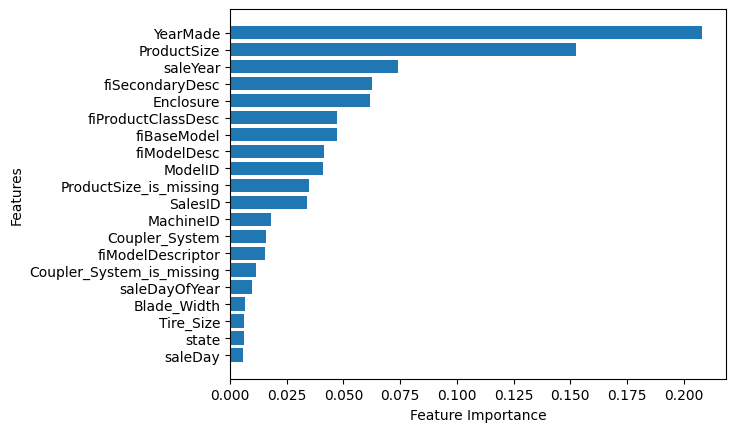

In [65]:
plot_features(df_test.columns, ideal_model.feature_importances_)

**Question to finish**: Why might knowing the feature importances of a trained machine learning model be helpful?
    
**Final Challenge:** What other machine learning models could you try on our dataset? Hint: Check out the regression section of scikit-learn model map, or try to look at something like CatBoost.ai or XGBoost.ai.